# Explore data

Simple notebook to explore the dataset

In [1]:
# mandatory stuff to get things working properly
import os
import json
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import utils
from gwpy.table import EventTable

import jax.numpy as jnp
from ripple import ms_to_Mc_eta, Mc_eta_to_ms

from bilby.gw.conversion import component_masses_to_chirp_mass, chirp_mass_and_mass_ratio_to_component_masses

rcparams = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(rcparams)

## Load in the selected detected events:

In [2]:
# Define the locations etc here:
my_outdir = "./injections_tidal/outdir/" # where the rundirs will come
data_dir = "./data_split/"
bns_o5 = data_dir + "bns_O5HL_injections.dat"
bns_o4 = data_dir + "bns_O4HL_injections.dat"

xml_filename_o5 = "/home/thibeau.wouters/gw-datasets/H0_inference_O5/events_O5.xml" # on CIT!
xml_filename_o4 = "/home/thibeau.wouters/gw-datasets/H0_inference_O4/events_O4.xml" # on CIT!

# Choose which to load:
which_run = "O5"

if which_run == "O5":
    xml_filename = xml_filename_o5
    bns = bns_o5
else:
    xml_filename = xml_filename_o4
    bns = bns_o4

# Load in the injections file first
data_dict = utils.read_injections_file(bns)

Sanity checking the code:

In [3]:
for key, value in data_dict.items():
    print(f"{key}: examples values {value[:5]}")
    
example_event_id = int(data_dict["simulation_id"][0])

simulation_id: examples values [ 9 14 21 23 24]
longitude: examples values [3.7971859  4.5625499  0.96535827 3.3950243  2.4084685 ]
latitude: examples values [ 0.87535684 -0.00339247  1.405876   -0.33706707  0.0869114 ]
inclination: examples values [0.38678959 0.32873468 2.6485628  2.3010108  0.26154381]
distance: examples values [203.77752 636.56451 226.54627 487.65838 443.7946 ]
mass1: examples values [2.0644817 1.9580471 2.1042908 2.1821147 2.0891864]
mass2: examples values [1.6678797 1.4436337 1.7786805 1.9537788 1.3713884]
spin1z: examples values [-0.06107824 -0.0595872  -0.09220774 -0.14975753  0.07147652]
spin2z: examples values [-0.0003123  -0.01736595  0.10383004 -0.05204631 -0.05826461]
polarization: examples values [1.33792651 6.27256107 5.72252846 3.25340319 1.80338764]
coa_phase: examples values [-2.08128214 -2.9611845   0.80135041  0.14345084 -2.74263024]
geocent_end_time: examples values [1.02630596e+09 1.02778482e+09 1.02535090e+09 1.02246412e+09
 1.02606043e+09]
geocen

## Need the SNR

The SNR is not in this file, but it is in the following file. NOTE: this dataset is stored on the LIGO LDAS CIT cluster, but it is the same as on the LHO cluster as computed by Weizmann at `/home/weizmann.kiendrebeogo/Andrew/HL-SNR-10/runs/`.

In [4]:
# Use the EventTable to read the XML file

table = EventTable.read(xml_filename, tablename = "coinc_inspiral")

# Get the keys of this table
keys = table.keys()
print("keys")
print(keys)

# Get some specific variables that I want to use
simulation_id_xml = np.array(table["coinc_event_id"])
snr_xml = np.array(table["snr"])
end_time = np.array(table["end_time"])

# Show the SNR of the above example
idx = np.where(simulation_id_xml == example_event_id)[0][0]
snr_example = snr_xml[idx]
end_time_example = end_time[idx]

print("snr_example")
print(snr_example)

print("end_time_example")
print(end_time_example)

keys
['coinc_event_id', 'combined_far', 'end_time', 'end_time_ns', 'false_alarm_rate', 'ifos', 'mass', 'mchirp', 'minimum_duration', 'snr']
snr_example
20.71345431810761
end_time_example
1026305955


This seems to be working fine, now let us put into a complete function

In [5]:
snr_array, ifos_array = utils.get_events_info(table, data_dict["simulation_id"])

print("Examples of SNR and ifos:")
print(snr_array[:5])
print(ifos_array[:5])

data_dict["snr"] = snr_array
data_dict["ifos"] = ifos_array
assert len(data_dict["ifos"]) == len(data_dict["simulation_id"]), "ifos and simulation_id have different lengths"

Examples of SNR and ifos:
[20.71345432 11.58412296 31.55944294 10.75187143 10.835764  ]
['H1,L1', 'H1,L1', 'H1,L1', 'H1,L1', 'H1,L1']


## Choosing the BNS events to tackle

### Checking the data

How to choose the BNS events to analyze?

In [6]:
print(data_dict.keys())

dict_keys(['simulation_id', 'longitude', 'latitude', 'inclination', 'distance', 'mass1', 'mass2', 'spin1z', 'spin2z', 'polarization', 'coa_phase', 'geocent_end_time', 'geocent_end_time_ns', 'redshift', 'source_mass1', 'source_mass2', 'snr', 'ifos'])


Number of runs:
549


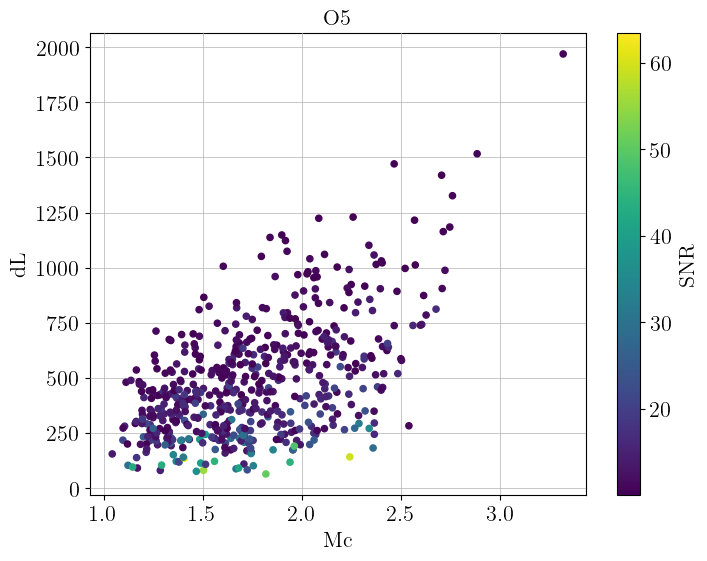

In [7]:
def make_scatterplot(data_dict: dict,
                     key1: str,
                     key2: str,
                     **plot_kwargs):
    
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.scatter(data_dict[key1], data_dict[key2], **plot_kwargs)
    ax.set_xlabel(key1)
    ax.set_ylabel(key2)
    plt.show()
    
# make_scatterplot(data_dict, "mass1", "mass2", c = data_dict["snr"], cmap = "viridis", s = 10)
print("Number of runs:")
print(len(data_dict["mass1"]))

mc = component_masses_to_chirp_mass(data_dict["mass1"], data_dict["mass2"])
fig, ax = plt.subplots(figsize = (8, 6))
scatter = ax.scatter(mc, data_dict["distance"], c = data_dict["snr"], cmap = "viridis", s = 20, zorder = 100)
ax.set_xlabel("Mc")
ax.set_ylabel("dL")
cbar = plt.colorbar(scatter, label = "SNR")
plt.title(which_run, fontsize = 16)
plt.show()

Take those with highest SNR, or randomly sample? What are the SNRs if we just take the top 50 ones?

In [8]:
max_nb = 30

sort_idx = np.argsort(data_dict["snr"])[::-1]
sampled_indices = sort_idx[:max_nb]

keys = ["snr", "mass1", "mass2", "spin1z", "spin2z", "distance"]

for key in keys:
    print(f"{key} min and max")
    values = data_dict[key][sampled_indices]
    print(np.min(values), np.max(values))

snr min and max
29.58638693287287 63.47535619216567
mass1 min and max
1.3134517 2.882293
mass2 min and max
1.2304333 2.5085646
spin1z min and max
-0.52561503 0.3665528
spin2z min and max
-0.32181532 0.28894358
distance min and max
64.043087 310.88067


## Testing generation of config files for the injections

In [9]:
print("Original dictionary length")
print(len(data_dict["simulation_id"]))

filtered_dict = utils.filter_dict_by_indices(data_dict, sampled_indices)

print("New dictionary length")
print(len(filtered_dict["simulation_id"]))

Original dictionary length
549
New dictionary length
30


Take an extreme case of a single entry to be saved:

In [10]:
# separate_dicts: ALL the injections but as a list of individual dicts
separate_dicts = utils.split_dict(data_dict)

print("len(separate_dicts)")
print(len(separate_dicts))

# selected_dicts: ONLY the chosen/selected injections as a list of individual dicts
selected_dicts = utils.split_dict(filtered_dict)
print("len(selected_dicts)")
print(len(selected_dicts))

len(separate_dicts)
549
len(selected_dicts)
30


## Get the final config files (low spin only)

Commented out for now since I don't need to create them anymore.

In [11]:
for config_dict in selected_dicts:
    _ = utils.generate_config(config_dict, "./injections_tidal/outdir/")

2024-06-27 08:15:01.017969: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Injection directory exists:  ./injections_tidal/outdir/injection_4067/
Injection directory exists:  ./injections_tidal/outdir/injection_238/
Injection directory exists:  ./injections_tidal/outdir/injection_129/
Injection directory exists:  ./injections_tidal/outdir/injection_3900/
Injection directory exists:  ./injections_tidal/outdir/injection_2693/
Injection directory exists:  ./injections_tidal/outdir/injection_81/
Injection directory exists:  ./injections_tidal/outdir/injection_2450/
Injection directory exists:  ./injections_tidal/outdir/injection_4390/
Injection directory exists:  ./injections_tidal/outdir/injection_3070/
Injection directory exists:  ./injections_tidal/outdir/injection_2912/
Injection directory exists:  ./injections_tidal/outdir/injection_2310/
Injection directory exists:  ./injections_tidal/outdir/injection_2392/
Injection directory exists:  ./injections_tidal/outdir/injection_1539/
Injection directory exists:  ./injections_tidal/outdir/injection_4747/
Injection 

### Check the created injections

In [12]:
# MTOV stuff
MTOV_middle = 2.26
MTOV_min = MTOV_middle - 0.22
MTOV_max = MTOV_middle + 0.45

dirs = os.listdir("./injections_tidal/outdir/")

print("len(dirs)")
print(len(dirs))

mass1 = []
mass2 = []
spin1z = []
spin2z = []
dL = []
snr = []

for d in dirs:
    path = os.path.join(os.path.join("./injections_tidal/outdir/", d), "config.json")
    with open(path, "r") as f:
        config = json.load(f)
    
    # Masses
    mc, q = config["M_c"], config["q"]
    m1, m2 = chirp_mass_and_mass_ratio_to_component_masses(mc, q)
    mass1.append(m1)
    mass2.append(m2)
    
    # Spins
    spin1z.append(config["s1_z"])
    spin2z.append(config["s2_z"])
    
    # Distance and SNR
    dL.append(config["d_L"])
    snr.append(config["snr"])

len(dirs)
30


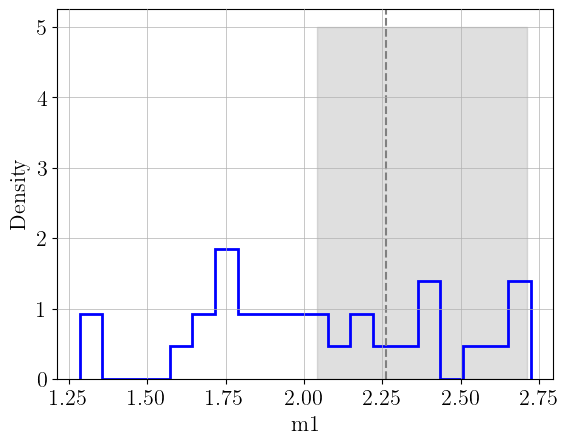

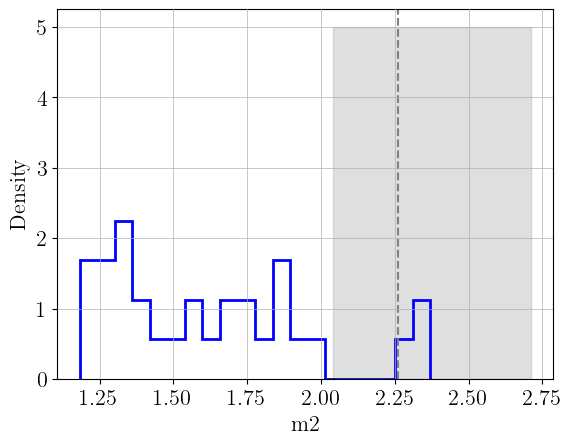

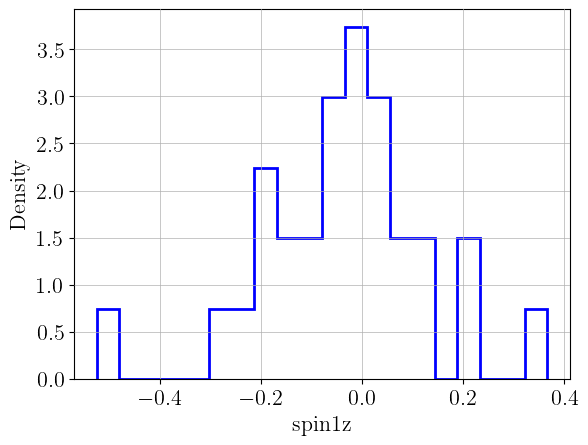

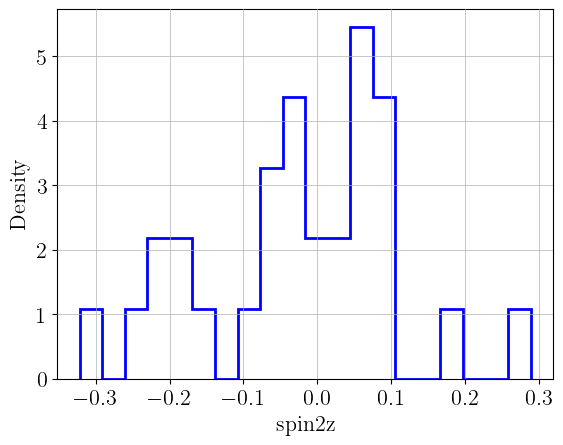

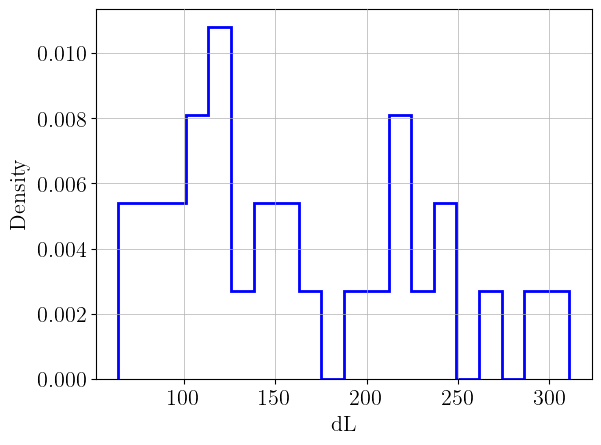

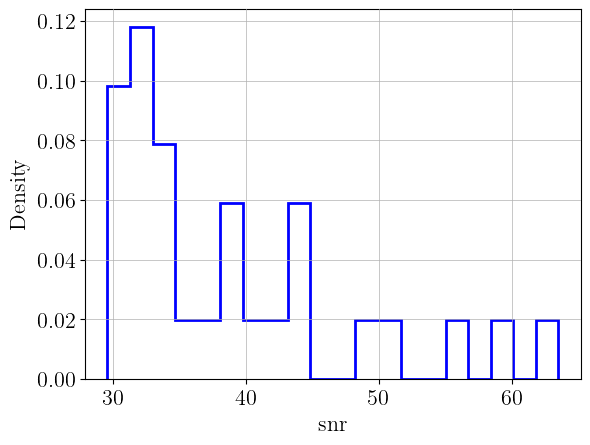

In [13]:
for values, name in zip([mass1, mass2, spin1z, spin2z, dL, snr], ["m1", "m2", "spin1z", "spin2z", "dL", "snr"]):
    plt.hist(values, bins = 20, histtype = "step", density=True, lw = 2, color = "blue")
    plt.xlabel(name)
    plt.ylabel("Density")
    if name in ["m1", "m2"]:
        ymin = 0
        ymax = 5
        plt.fill_between([MTOV_min, MTOV_max], ymin, ymax, color = "gray", alpha = 0.25, label = r"$M_{\rm{TOV}}$ bound")
        plt.axvline(MTOV_middle, ymin=ymin, ymax=ymax, color = "gray", linestyle = "--")
    plt.show()

# === Archive === 

In [14]:
# # Select dicts that have spins between -0.05 and 0.05
# MTOV_threshold = 2.25
# passes_criterion = lambda x: (x["mass1"] < MTOV_threshold) * (x["mass2"] < MTOV_threshold) * (abs(x["spin1z"]) < 0.05) * (abs(x["spin2z"]) < 0.05)
# selected_dicts = [d for d in separate_dicts if passes_criterion(d)]
# print(f"Number of low spin: {len(selected_dicts)}")
# print(selected_dicts[0]) # an example:

Spins are large?

In [15]:
# s1z = data_dict["spin1z"]
# s2z = data_dict["spin2z"]
# simulation_id_list = data_dict["simulation_id"]

# hist_1, bins = np.histogram(s1z, bins = 20, density=True)
# hist_2, _ = np.histogram(s2z, bins = bins, density=True)

# for hist, label in zip([hist_1, hist_2], ["Spin 1", "Spin 2"]):
#     plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
# plt.legend()
# plt.xlabel("Spin")
# plt.ylabel("Density")
# plt.show()

Selected dicts:

In [16]:
# def get_values_by_key(list_of_dicts: list[dict], key: str):
#     return np.array([d[key] for d in list_of_dicts])

# spin1z = get_values_by_key(selected_dicts, "spin1z")
# spin2z = get_values_by_key(selected_dicts, "spin2z")
# mass1 = get_values_by_key(selected_dicts, "mass1")
# mass2 = get_values_by_key(selected_dicts, "mass2")
# snr = get_values_by_key(selected_dicts, "snr")

# hist_1, bins = np.histogram(spin1z, bins = 20, density=True)
# hist_2, _ = np.histogram(spin2z, bins = bins, density=True)

# for hist, label in zip([hist_1, hist_2], ["Spin 1", "Spin 2"]):
#     plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
# plt.legend()
# plt.xlabel("Spin")
# plt.ylabel("Density")
# plt.show()

# hist_1, bins = np.histogram(mass1, bins = 20, density=True)
# hist_2, _ = np.histogram(mass2, bins = bins, density=True)
# for hist, label in zip([hist_1, hist_2], ["Mass 1", "Mass 2"]):
#     plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
# # Show the bands from Hauke's paper: https://arxiv.org/abs/2402.04172
# middle = 2.26
# xmin = middle - 0.22
# xmax = middle + 0.45
# ymin = 0
# ymax = 5
# plt.fill_between([xmin, xmax], ymin, ymax, color = "gray", alpha = 0.25, label = r"$M_{\rm{TOV}}$ bound")
# plt.axvline(middle, ymin=ymin, ymax=ymax, color = "gray", linestyle = "--")
# plt.xlabel("Mass")
# plt.ylabel("Density")
# plt.legend()
# plt.show()


# hist, bins = np.histogram(snr, bins = 20, density=True)
# plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)
# plt.legend()
# plt.xlabel("SNR")
# plt.ylabel("Density")
# plt.show()

Plot the created data

In [17]:
# # Analyze the selected events:
# subdirs = os.listdir(my_outdir)
# dL_list = [] 
# spin1_list = []
# spin2_list = []
# snr_list = []

# for subdir in subdirs:
#     if not os.path.isdir(my_outdir + subdir):
#         continue
        
#     # Load the config and save dL, chi1, chi2
#     with open(my_outdir + subdir + "/config.json", "r") as f:
#         config = json.load(f)
        
#         dL, chi1, chi2, snr = config["d_L"], config["s1_z"], config["s2_z"], config["snr"]
#         dL_list.append(dL)
#         spin1_list.append(chi1)
#         spin2_list.append(chi2)
#         snr_list.append(snr)
        
#         # Hacky way
#         if snr > 40:
#             print(f"High SNR: {snr}, subdir: {subdir}")
# # Make histograms

# for values, label in zip([dL_list, spin1_list, spin2_list, snr_list], ["dL", "Spin 1", "Spin 2", "SNR"]):
#     hist, bins = np.histogram(values, bins = 20, density = True)
#     plt.stairs(hist, bins, fill = False, linewidth = 2)
#     plt.xlabel(label)
#     plt.ylabel("Density")
#     plt.show()


# m1_list = []
# m2_list = []

# for subdir in subdirs:
#     if not os.path.isdir(my_outdir + subdir):
#         continue
        
#     # Load the config and save dL, chi1, chi2
#     with open(my_outdir + subdir + "/config.json", "r") as f:
#         config = json.load(f)
        
#         mc, q = config["M_c"], config["q"]
#         eta = q / (1 + q)**2
#         m1, m2 = Mc_eta_to_ms(jnp.array([mc, eta]))
        
#         m1_list.append(m1)
#         m2_list.append(m2)
        
# # Make histograms
# plt.figure(figsize = (10, 5))
# for values, label in zip([m1_list, m2_list], [r"$m_1$", r"$m_2$"]):
#     hist, bins = np.histogram(values, bins = 20)
#     plt.stairs(hist, bins, fill = False, linewidth = 2, label = label)

# # Finalize plot
# plt.xlabel("Mass")
# plt.ylabel("Density")
# # Show the bands from Hauke's paper: https://arxiv.org/abs/2402.04172
# middle = 2.26
# xmin = middle - 0.22
# xmax = middle + 0.45
# ymin = 0
# ymax = 5
# plt.fill_between([xmin, xmax], ymin, ymax, color = "gray", alpha = 0.25, label = r"$M_{\rm{TOV}}$ bound")
# plt.axvline(middle, ymin=ymin, ymax=ymax, color = "gray", linestyle = "--")
# plt.legend()
# plt.show()

Old way to get the desired low spin

In [18]:
# # Count how many events have a spins 1 and 2 between -0.05 and 0.05
# low_spin_indices = []
# MAX_NB = 30 # max number of runs to save

# nb_events_low_spin = 0
# for (sim_id, s1, s2) in enumerate(zip(simulation_id_list, s1z, s2z)):
#     if -0.05 < s1 < 0.05 and -0.05 < s2 < 0.05:
#         nb_events_low_spin += 1
#         low_spin_indices.append(sim_id)
        
# print(f"Number of events with spins between -0.05 and 0.05: {nb_events_low_spin}")

# print("low_spin_indices")
# print(low_spin_indices)

# test_idx = low_spin_indices[2]
# print(test_idx)
# print(data_dict["spin1z"][test_idx])
# print(data_dict["spin2z"][test_idx])

# # Show their SNR, sorted from high to low
# snr_low_spin = snr_array[low_spin_indices]
# sorted_snr_low_spin_idx = np.argsort(snr_low_spin)[::-1]
# sorted_snr_low_spin = snr_low_spin[sorted_snr_low_spin_idx]
# sorted_simulation_low_spin_idx = data_dict["simulation_id"][low_spin_indices][sorted_snr_low_spin_idx]

# # Save the highest SNR up to MAX_NB
# nb_to_save = min(MAX_NB, len(sorted_snr_low_spin))
# print(f"Saving {nb_to_save} highest SNR events")
# for i in range(nb_to_save):
#     idx = sorted_snr_low_spin_idx[i]
#     print(f"Saving event {idx}")
#     filtered_dict = utils.filter_dict_by_indices(data_dict, [idx])
#     utils.generate_config(filtered_dict, my_outdir)

# print("sorted_snr_low_spin")
# print(sorted_snr_low_spin)

# # Show the first simulation ID with highest SNR
# print("sorted_simulation_low_spin_idx highest SNR")
# print(low_spin_indices[sorted_snr_low_spin_idx[0]])

## What priors should I use?

In [19]:
# m1 = data_dict["source_mass1"]
# m2 = data_dict["source_mass2"]
# print(f"m1 varies between {np.min(m1)} and {np.max(m1)}")
# print(f"m2 varies between {np.min(m2)} and {np.max(m2)}\n")

# # Compute the chirp mass for this
# mc, _ = ms_to_Mc_eta(jnp.array([m1, m2]))
# print(f"mc varies between {np.min(mc)} and {np.max(mc)}")